In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBClassifier
%matplotlib inline

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

- grid search랑 rfecv 같이 돌리는 방법

    https://stackoverflow.com/questions/55609339/how-to-perform-feature-selection-with-gridsearchcv-in-sklearn-in-python
    
- machine learning model 장단점
    
    https://dohk.tistory.com/170

- multi class의 f1-score (average : None, 'micro', 'macro', 'weighted')
    - macro : 클래스 불균형을 고려하지 않음
    
    https://nittaku.tistory.com/295
    
    
-참고 : 랜덤포레스트는 min_samples_leaf가 적절하게 설정 될 때 꽤 좋은 확률 추정치를 제공

- SVC의 kernel 종류와 파라미터의 영향

    https://datascienceschool.net/view-notebook/69278a5de79449019ad1f51a614ef87c/


- classifier 종류


    [XGBClassifier(),              LGBMClassifier(), 
     ExtraTreesClassifier(),       ExtraTreeClassifier(),
     BaggingClassifier(),          DecisionTreeClassifier(),
     GradientBoostingClassifier(), LogisticRegression(),
     AdaBoostClassifier(),         RandomForestClassifier(),           SVC()]


In [ ]:
# 참고
# StratifiedShuffleSplit

In [2]:
activity_dir = 'C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_activity.csv'
combat_dir = 'C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_combat.csv'
trade_dir = 'C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_trade.csv'
label_dir ='C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_label_add.csv'
pay_dir = 'C:/Users/Affinity/Desktop/study/빅콘테스트/2019빅콘테스트_챔피언스리그_데이터_수정/train_payment.csv'

train_activity = pd.read_csv(activity_dir)
train_combat = pd.read_csv(combat_dir)
train_trade = pd.read_csv(trade_dir)
train_label = pd.read_csv(label_dir)
del train_label['Unnamed: 0']
train_payment = pd.read_csv(pay_dir)

In [3]:
merge_all = pd.read_csv('./merge_all.csv')

In [4]:
merge_all.shape

(40000, 782)

In [5]:
merge_all = pd.merge(merge_all, train_label, on = 'acc_id', how='outer').fillna(0)
merge_all.shape

(40000, 786)

In [8]:
merge_all.columns[-4:]

Index(['survival_time', 'amount_spent_y', 'secession', 'total_spent'], dtype='object')

In [15]:
# label과 merge로 인해 payment의 amount_spent에 _x가 추가됨
# 실제로 leaderboard에 올릴 때에는 label을 합치지 않으므로 _x가 붙을일이 없음
# 따라서 rename을 통해 payment의 amount_spent_x를 amount_spent로 변경
merge_all.rename(columns={'amount_spent_x':'amount_spent'}, inplace = True)

#### 64 category별 빈도

In [39]:
pd.DataFrame(merge_all.survival_time.value_counts()).reset_index().sort_values('index')

,index,survival_time
3,1,1012
7,2,483
4,3,719
5,4,712
20,5,269
21,6,264
22,7,262
2,8,1219
13,9,343
9,10,462


In [30]:
merge_all.survival_time.value_counts().min()

89

<BarContainer object of 64 artists>

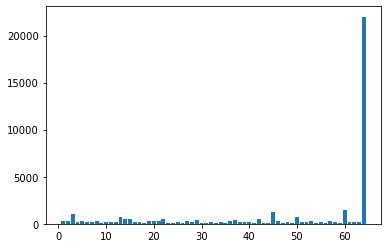

In [29]:
# survival time 비율
plt.bar(merge_all.survival_time.unique(),merge_all.survival_time.value_counts())

In [274]:
merge_all.secession.value_counts()

0    21996
1    18004
Name: secession, dtype: int64

#### 잔존(=64)을 가장 잘 분류하는 threshold 찾기

In [292]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all.drop(['acc_id',
                                 'class',
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time'], axis=1),
                                 merge_all.secession,
                                 test_size = 0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 780), (7000, 780), (12000, 780), (21000,), (7000,), (12000,))

In [289]:
import xgboost as xgb

params = {'n_estimators' : 475,
         'learning_rate' : 0.1,
          'nthread' : 15,
          'num_boost_round' : 300,
         'max_depth' : 6,
          'eval_metric' : 'auc',
          'gamma' : 1,
          'subsample' : 0.9}

VALID = True
np.random.seed(42)
if VALID == True:
    
    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model = xgb.train(params, tr_data, 1000, watchlist, verbose_eval = 50, early_stopping_rounds=30)

[0]	train-auc:0.815262	valid-auc:0.791977
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.918478	valid-auc:0.83809
[100]	train-auc:0.945818	valid-auc:0.842056
[150]	train-auc:0.962368	valid-auc:0.844464
[200]	train-auc:0.972658	valid-auc:0.845114
[250]	train-auc:0.979188	valid-auc:0.84603
[300]	train-auc:0.982423	valid-auc:0.84643
Stopping. Best iteration:
[310]	train-auc:0.982946	valid-auc:0.846594



- 임계값 비교

In [281]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = np.where(model.predict(xgb.DMatrix(X_test)) > 0.4, 1, 0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.7599166666666667, 0.7563224223970227, 0.8235294117647058, 4648, 5644)

In [282]:
# f1-score가 최대인 부분
from sklearn.metrics import accuracy_score, f1_score
y_pred = np.where(model.predict(xgb.DMatrix(X_test)) > 0.009, 1, 0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision,((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.4850833333333333, 0.6382953813732951, 0.9609375, 369, 384)

In [283]:
# f1-score가 최대인 부분 (0.042랑 비슷)
from sklearn.metrics import accuracy_score, f1_score
y_pred = np.where(model.predict(xgb.DMatrix(X_test)) > 0.055, 1, 0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision,((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.5415833333333333, 0.6634032919292663, 0.9590747330960854, 1078, 1124)

In [284]:
# f1-score가 최대인 부분 (0.042랑 비슷)
from sklearn.metrics import accuracy_score, f1_score
y_pred = np.where(model.predict(xgb.DMatrix(X_test)) > 0.1, 1, 0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision,((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.5884166666666667, 0.6847111394829237, 0.9422863485016648, 1698, 1802)

#### grid search

In [311]:
import xgboost as xgb

np.random.seed(42)

xg_reg = xgb.XGBClassifier(n_estimators = 475, learning_rate = 0.1, nthread = 15, max_depth = 8,
                        gamma = 0, subsample=0.9)


eval_set = [(X_train, y_train), (X_valid, y_valid)]

xg_reg.fit(dX_train,dy_train, eval_set = eval_set, early_stopping_rounds=20)


ValueError: bad input shape ()

In [306]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = np.where(xg_reg.predict_proba(X_test)[:,1] > 0.055,1,0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.5515833333333333, 0.6685964155940137, 0.9682926829268292, 1191, 1230)

In [315]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all.drop(['acc_id',
                                 'class',
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time'], axis=1),
                                 merge_all.secession,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 780), (12000, 780), (28000,), (12000,))

In [317]:
from sklearn.model_selection import StratifiedKFold
# GridSearchCV with XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
param_grid = {'objective':['binary:logistic'],
              'nthread':[4],
              'learning_rate': [0.001,0.05,0.1, 10], 
              'max_depth': [2,3,4,5,6],
              'min_child_weight': [11],
              'subsample': [0.8,0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [1000]
#              ,'eval_set':[[X_valid, y_valid]]
             } 

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator = xgb_model, cv=kfold, param_grid = param_grid , scoring = 'roc_auc', verbose = 20, n_jobs = -1, refit=True)
# n_jobs(default=1) : 내부적으로 멀티 프로세스를 사용하여 그리드 서치를 수행
# 만약 CPU 코어의 수가 충분하다면 n_jobs를 늘릴 수록 속도가 증가한다
grid.fit(X_train,y_train)

# param_grid의 모든 파라미터 조합에 대한 성능 결과.
# parameters : 사용된 파라미터
# mean_validation_score : 교차 검증(cross-validation) 결과의 평균값
# cv_validation_scores : 모든 교차 검증(cross-validation) 결과
print("Best Score:" + str(grid.best_score_))
# 최고 점수를 낸 파라미터 출력
print("Best Parameters: " + str(grid.best_params_))

best_parameters = grid.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 54

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 557.4min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 558.0min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 558.1min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 558.9min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 566.8min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 568.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 581.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 581.8min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 592.9min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 593.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 603.3min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 604.4min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 614.6min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 616.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 628.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 6

Best Score:0.8564739159475555
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'subsample': 0.9}


In [318]:
# 최고 점수를 낸 파라미터를 가진 모형
print("Best Estimator: ", grid.best_estimator_)

Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)


In [ ]:
# model save
import pickle
with open('C:/Users/Affinity/Desktop/study/빅콘테스트/grid_model_01.pkl', 'wb') as f:
    pickle.dump(grid, f)

# with open('C:/Users/Affinity/Desktop/study/빅콘테스트/grid_model_01.pkl', 'rb') as f:
#     loded_model = pickle.load('C:/Users/Affinity/Desktop/study/빅콘테스트/grid_model_01')

# y_pred = np.where(loded_model.predict_proba(X_test)[:,1] > 0.5, 1, 0)

가장 높은 임계값 찾기

In [447]:
test_probs = np.where(grid.best_estimator_.predict_proba(X_test)[:,1] > 0.5, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (test_probs == 0)).sum() / (test_probs == 0).sum()
accuracy_score(y_test, test_probs), f1_score(y_test, test_probs), precision, ((y_test == 0) & (test_probs == 0)).sum(),(test_probs==0).sum()

(0.7773333333333333, 0.7483518553399887, 0.7818659658344284, 5355, 6849)

In [448]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_probs))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      6533
           1       0.77      0.73      0.75      5467

    accuracy                           0.78     12000
   macro avg       0.78      0.77      0.77     12000
weighted avg       0.78      0.78      0.78     12000



In [386]:
test_probs = np.where(grid.best_estimator_.predict_proba(X_test)[:,1] > 0.051, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (test_probs == 0)).sum() / (test_probs == 0).sum()
accuracy_score(y_test, test_probs), f1_score(y_test, test_probs), precision, ((y_test == 0) & (test_probs == 0)).sum(),(test_probs==0).sum()

(0.5734166666666667, 0.6789589212919411, 0.9645203679369251, 1468, 1522)

In [401]:
test_probs = np.where(grid.best_estimator_.predict_proba(X_test)[:,1] > 0.30, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (test_probs == 0)).sum() / (test_probs == 0).sum()
accuracy_score(y_test, test_probs), f1_score(y_test, test_probs), precision, ((y_test == 0) & (test_probs == 0)).sum(),(test_probs==0).sum()

(0.75275, 0.7629623711752018, 0.8602020202020202, 4258, 4950)

In [513]:
y_scores = grid.best_estimator_.predict_proba(X_test)[:,1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)

     pred_neg  pred_pos
neg      4258      2275
pos       692      4775


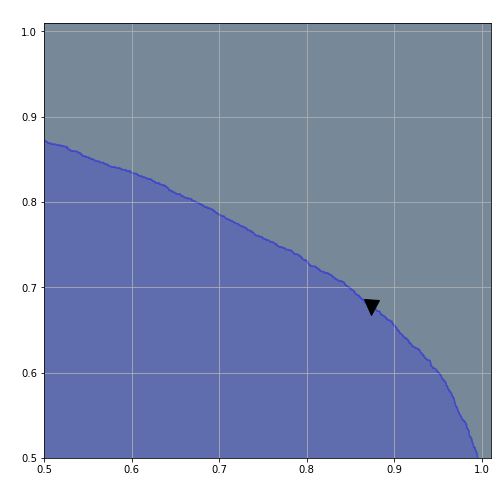

In [516]:
def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(p, r, thresholds, t=0.5):
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
#     plt.figure(figsize=(8,8))
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(1,1,1)
    plt.title("Precision and Recall curve, v = current threshold",c='w')
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01])
    plt.xlim([0.5, 1.01])
    plt.xlabel('Recall',c='w')
    plt.ylabel('Precision',c='w')
    plt.grid(True)
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], marker='v', c='k',
            markersize=15) 
    ax.set_facecolor('lightslategray')

    
precision_recall_threshold(p, r, thresholds, 0.3)

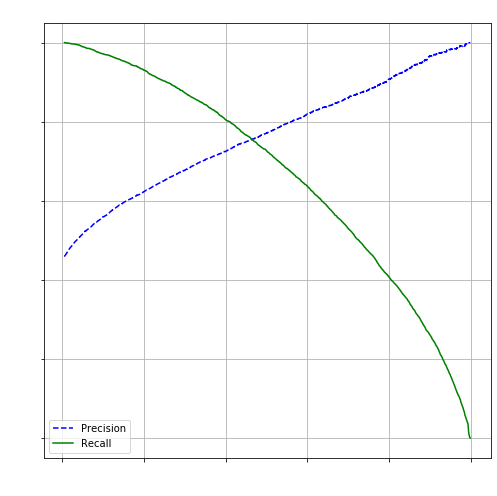

In [480]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold",c = 'w')
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score", c = 'w')
    plt.xlabel("Decision Threshold",c = 'w')
    plt.xticks(c='w')
    plt.yticks(c='w')
    plt.legend(loc='best')
    plt.grid(b=True, which='both', axis='both')
    
plot_precision_recall_vs_threshold(p, r, thresholds)

0.8631960696732613


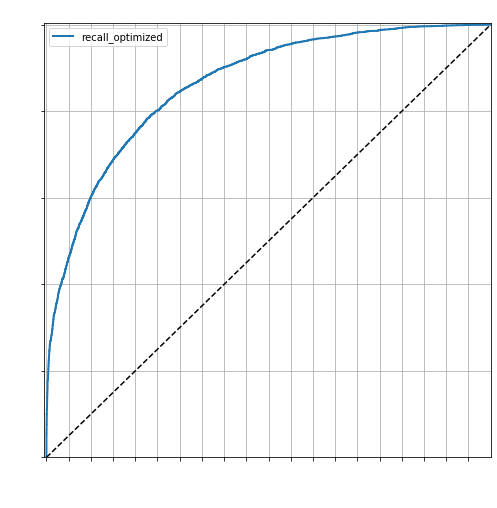

In [483]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve',c='w')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90,c='w')
    plt.yticks(c='w')
    plt.xlabel("False Positive Rate",c='w')
    plt.ylabel("True Positive Rate (Recall)",c='w')
    plt.grid(True)
    plt.legend(loc='best')
    
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr))
plot_roc_curve(fpr, tpr, 'recall_optimized')

##### 번외

- tree model과 비교
    - 확실히 tree model이 imbalanced data에 대하여 더 좋은 성능을 가짐
    - 64 category를 진행할 떄 tree model을 사용하는 것이 효과적일 것으로 판단
    
    
- tree의 bagging과 boosting의 차이
    - https://www.slideshare.net/freepsw/boosting-bagging-vs-boosting
    
- adaboost : 다수결을 통한 정답 분류 및 오답에 가중치 부여 (모델이 잘 예측하지 못하는 부분 보완)
- GBM : loss function의 gradient를 통해 오답에 가중치 부여 (오차가 큰 모델 상쇄) - Xgb 하위호환
- Lignt GBM :
    - Xgboost 대비 성능 향상 및 자원소모 최소화
    - Xgboost가 처리하지 못하는 대용량 데이터 학습 가능
    - Approximates the split(근사치의 분할)을 통한 성능 향상

In [449]:
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

extra_clf = ExtraTreesClassifier(n_estimators = 1000, max_depth = 30,
                                 criterion = 'gini', random_state = 42)
extra_clf.fit(X_train, y_train)
y_pred = extra_clf.predict(X_test)


precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
print('accuracy :', accuracy_score(y_test, y_pred),
     'f1-score :', f1_score(y_test, y_pred),
     'precision :', precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum())

accuracy : 0.7830833333333334 f1-score : 0.7492051257346566 precision : 0.7772291196388262 5355 6849


In [446]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      6533
           1       0.79      0.71      0.75      5467

    accuracy                           0.78     12000
   macro avg       0.78      0.78      0.78     12000
weighted avg       0.78      0.78      0.78     12000



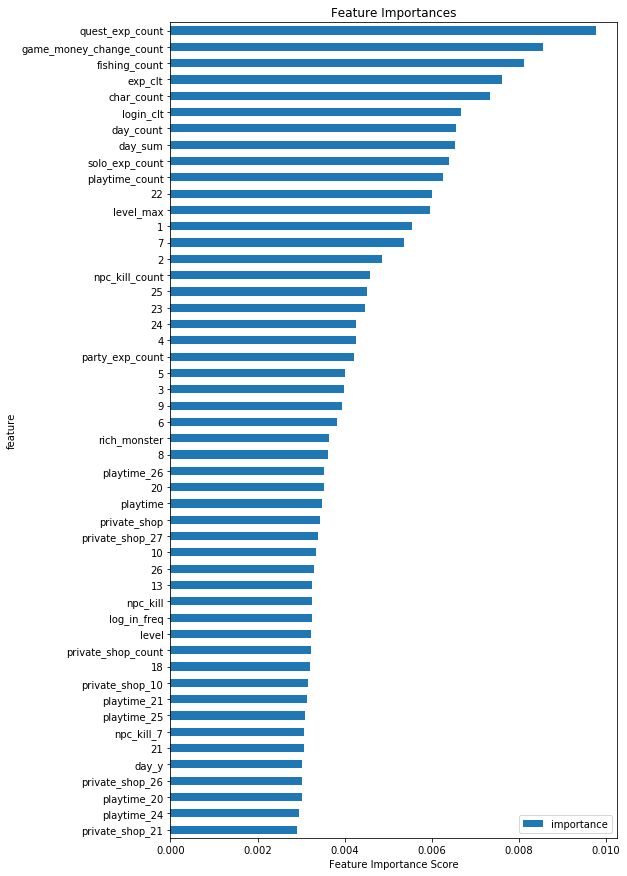

In [450]:
feat_imp1 = pd.DataFrame({'importance':extra_clf.feature_importances_})    
feat_imp1['feature'] = X_train.columns
feat_imp1.sort_values(by='importance', ascending=False, inplace=True)
feat_imp1 = feat_imp1.iloc[:50]
    
feat_imp1.sort_values(by='importance', inplace=True)
feat_imp1 = feat_imp1.set_index('feature', drop=True)
feat_imp1.plot.barh(title='Feature Importances', figsize=(8,15))
plt.xlabel('Feature Importance Score')
plt.show()

In [506]:
y_preda = extra_clf.predict_proba(X_test)[:,1]
p, r, thresholds = precision_recall_curve(y_test, y_preda)

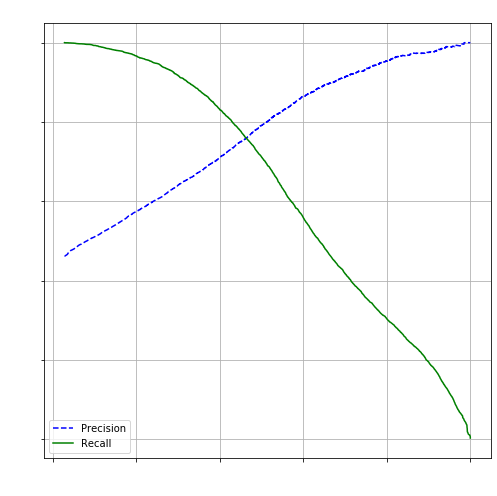

In [481]:
plot_precision_recall_vs_threshold(p, r, thresholds)

#### feature selection

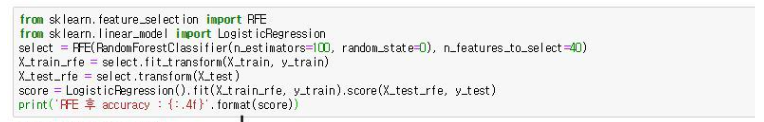

https://dlsdn73.tistory.com/818

이 사이트도 참조하면 좋음

http://cican17.com/data-visualization-with-python/ -> visualization

In [ ]:
# feature importance 그래프만 찍어보기
# grid search한 건 best_estimator_를 통해 분류기로 접근
model.feature_importances_
xgb.plot_importance(model)
model.booster().get_score(importance_type = 'weight')


importances = model.get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()),
                                'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8),
                      color = 'orange')

In [421]:
grid.best_estimator_.feature_importances_

array([0.00081961, 0.00082976, 0.00218397, 0.00478946, 0.00096904,
       0.00048125, 0.00105421, 0.00092235, 0.00083685, 0.00083027,
       0.00342137, 0.00162232, 0.00113567, 0.00081942, 0.00295798,
       0.00115196, 0.00076761, 0.00073616, 0.00129364, 0.00105379,
       0.00028584, 0.00117264, 0.00083206, 0.00088136, 0.00152906,
       0.00120335, 0.        , 0.00113032, 0.00076633, 0.04069236,
       0.00253432, 0.0033977 , 0.00422291, 0.00735683, 0.00082568,
       0.00147816, 0.00080346, 0.00094236, 0.00194195, 0.00089233,
       0.0083899 , 0.00056942, 0.00106696, 0.00059667, 0.0006495 ,
       0.        , 0.        , 0.00048074, 0.00089431, 0.00094128,
       0.00053482, 0.00104916, 0.        , 0.        , 0.00068888,
       0.00113355, 0.00045014, 0.        , 0.00079531, 0.00065182,
       0.00076702, 0.00058644, 0.00097485, 0.        , 0.00059652,
       0.00054334, 0.00151758, 0.00390565, 0.0051254 , 0.        ,
       0.000659  , 0.        , 0.00092151, 0.00330671, 0.00090

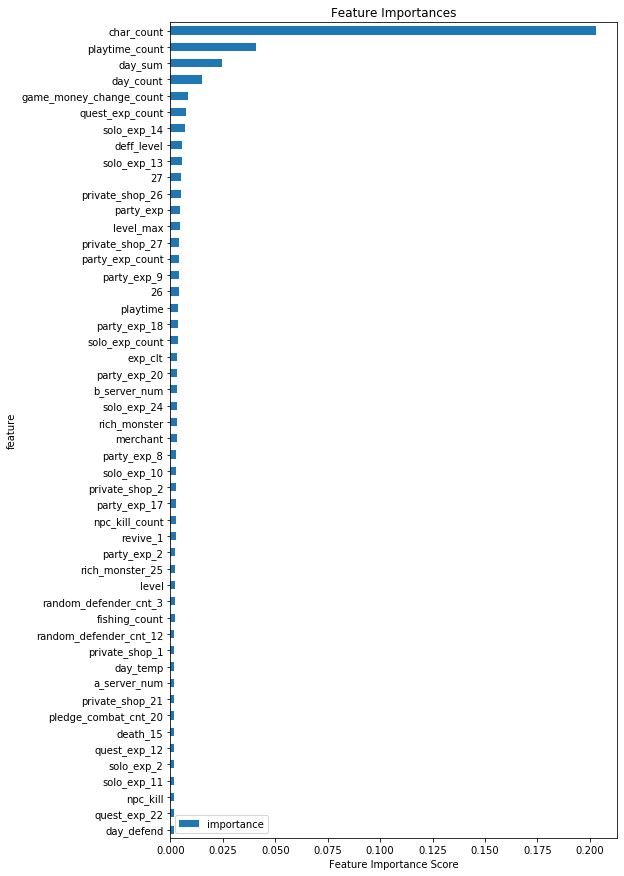

In [452]:
feat_imp = pd.DataFrame({'importance':grid.best_estimator_.feature_importances_})    
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:50]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Feature Importances', figsize=(8,15))
plt.xlabel('Feature Importance Score')
plt.show()

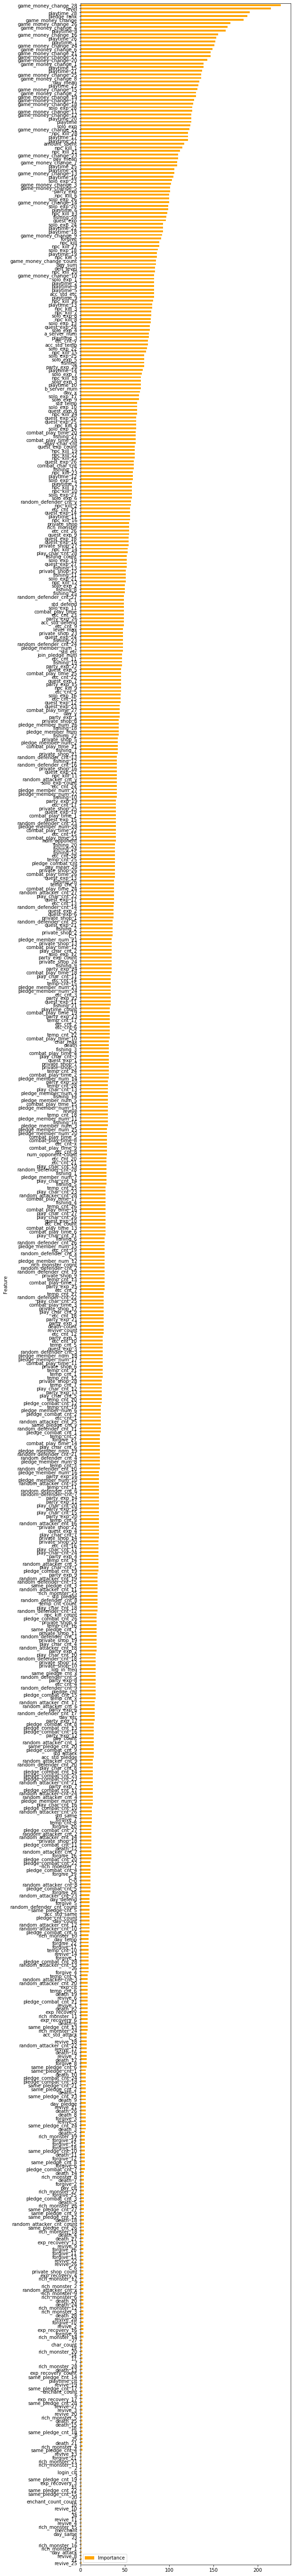

In [464]:
importances = grid.best_estimator_.get_booster().get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()),
                                'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
# importance_frame = importance_frame.iloc[:200]
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,100),
                      color = 'orange')

# RFE 돌려보기

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
# rfe('basic', 'perm', 'shap')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [4]:
merge_all_flatten = pd.read_csv('./merge_all_flatten.csv')
merge_all = pd.merge(merge_all_flatten, train_label, on = 'acc_id')
merge_all.rename(columns = {'amount_spent_x' : 'amount_spent'}, inplace = True)

In [5]:
merge_all_sub = merge_all.copy()

In [6]:
time_freq = pd.DataFrame(merge_all_sub['survival_time'].value_counts()).reset_index()
time_freq.columns = ['survival_time', 'freq']

In [7]:
dic = {}
for i in range(1,13):
    dic[i] = 1
    
for j in range(13,30):
    dic[j] = 2
    
for z in range(30,64):
    dic[z] = 3

dic[64] = 4

time_freq['range'] = time_freq['survival_time'].map(dic)

In [8]:
merge_all_sub['survival_term'] = merge_all_sub['survival_time'].map(dic)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all_sub.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 merge_all_sub.survival_term,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 401), (12000, 401), (28000,), (12000,))

In [605]:
gbc = xgb.XGBClassifier( # param 바꾸기
              colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000)
sel = RFE(gbc, n_features_to_select=200, verbose=1)

sel.fit(X_train, y_train)

X_train_rfe = sel.fit_transform(X_train, y_train)
# X_test_rfe = sel.transform(X_test)

# gbc.fit(X_train_rfe, y_train)
# score = model.score(X_test_rfe, y_test)
print (sel.ranking_)
print(sel.support_)
print(fit.n_features_)

Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.


KeyboardInterrupt: 

In [ ]:
import pickle
with open('./rfe_feature_selection.pkl', 'wb') as f:
    pickle.dump(grid, f)

In [ ]:
train_predict = sel.predict(X_train)
roc_auc_score(y_train, train_predict)

In [ ]:
# Use RFECV to pick best features, using Stratified Kfold
rfecv =   RFECV(estimator = gbc, cv=StratifiedKFold(y_train, 4), scoring='roc_auc')
# Fit the features to the response variable
rfecv.fit(X_train, y_train)

print("support:", rfecv.support_)

# Put the best features into new df X_new
X_new = rfecv.transform(X_train)
# or
X_new = rfecv.fit_transform(X_train, y_train)

### 대략 1개 / 1hour의 속도로 제거되서 select from model로 변경

In [638]:
%%time
threshholds = ["0.9*mean", "1.1*mean"]
#["0.8*mean","0.9*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean"

X_tr = X_train.drop('acc_id', axis=1)
y_tr = y_train
X_ts = X_test.drop('acc_id', axis=1)

# save list
features_index = []
features_name = []
predict_value = []
i=0

# 출력할 columns명을 확인하기 위해
aa = merge_all_flatten.drop('acc_id',axis=1)

for thresh in threshholds:
    model_ta = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000)

    select_ta = SelectFromModel(model_ta, threshold=thresh)
    select_ta.fit(X_tr,y_tr)

    X_train_s1_ta = select_ta.transform(X_tr)
    X_test_s1_ta = select_ta.transform(X_ts)
  
    print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  
    # feature name save
    feature_idx_all = select_ta.get_support()
    feature_name_all = aa[aa.columns[0:]].columns[feature_idx_all]
  
    # 값 리스트 저장
    features_index.append(feature_idx_all)
    features_name.append(feature_name_all)

X_train_s1.shape : (28000, 80)
X_train_s1.shape : (28000, 31)


In [ ]:
import xgboost as xgb

np.random.seed(42)


xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


eval_set = [(X_train[list(features_name[1])], y_train), (X_valid[list(features_name[1])], y_valid)]


xg_clf.fit(X_train[list(features_name[1])], y_train, eval_set = eval_set, verbose = 0)
    
y_pred = xg_clf.predict(X_test[list(features_name[1])])

print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'))
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
print(((y_pred == 2).sum()&(y_test==2).sum()) / (y_test==2).sum())
print(((y_pred == 3).sum()&(y_test==3).sum()) / (y_test==3).sum())
print(((y_pred == 4).sum()&(y_test==4).sum()) / (y_test==4).sum())


##### feature selection한 data에 weight를 주면 자꾸 터짐 따라서, 그냥 merge_all_flatten으로 실행

In [10]:
merge_all_flatten = pd.read_csv('./merge_all_flatten.csv')

In [11]:
merge_all = pd.merge(merge_all_flatten, train_label, on='acc_id')
merge_all.shape

(40000, 405)

In [12]:
merge_all.rename(columns = {'amount_apent_x':'amount_spent'}, inplace = True)

In [13]:
merge_all_sub = merge_all.copy()

In [14]:
time_freq = pd.DataFrame(merge_all_sub['survival_time'].value_counts()).reset_index()
time_freq.columns = ['survival_time', 'freq']

In [15]:
dic = {}
for i in range(1,13):
    dic[i] = 1
    
for j in range(13,30):
    dic[j] = 2
    
for z in range(30,64):
    dic[z] = 3

dic[64] = 4

time_freq['range'] = time_freq['survival_time'].map(dic)

In [16]:
merge_all_sub['survival_term'] = merge_all_sub['survival_time'].map(dic)

In [17]:
survival_term1 = merge_all_sub[(merge_all_sub.survival_term == 1)]
survival_term2 = merge_all_sub[(merge_all_sub.survival_term == 2)]
survival_term3 = merge_all_sub[(merge_all_sub.survival_term == 3)]

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(survival_term3.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 survival_term3.survival_time,
                                 test_size = 0.3, random_state=42)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3811, 401), (3811,), (1634, 401), (1634,))

In [28]:
import xgboost as xgb

np.random.seed(42)

xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000)


xg_clf.fit(X_train.drop('acc_id', axis=1),y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=12,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9, verbosity=1)

In [31]:
import pickle
with open('./cluster3.pkl', 'wb') as f:
    pickle.dump(xg_clf, f)

In [29]:
from sklearn.metrics import f1_score
y_pred = xg_clf.predict(X_test.drop('acc_id', axis=1))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.18053855569155447, 0.17734436671712583)

(0, 420)

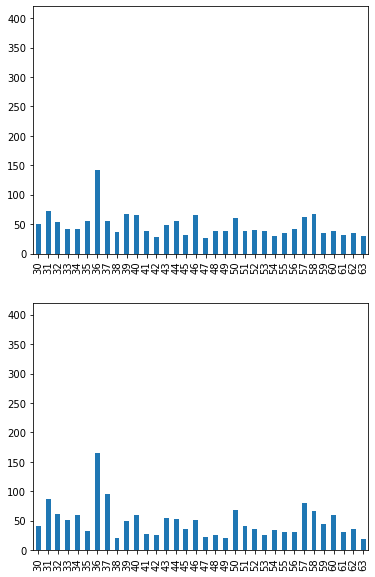

In [30]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,420])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,420])

In [ ]:
import pickle
with open('/content/drive/My Drive/grid_model_bin.pkl', 'rb') as f:
    grid_model_bin = pickle.load(f)

#### 느린 관계로 feature select은 colab에서 하고 jupyter에서는 결과 기반 검증

In [4]:
merge_best_feature = pd.read_csv('./merge_best_feature.csv')

In [5]:
merge_df = pd.merge(merge_best_feature, train_label, on='acc_id')
merge_df.shape

(40000, 244)

In [6]:
time_freq = pd.DataFrame(merge_df['survival_time'].value_counts()).reset_index()
time_freq.columns = ['survival_time', 'freq']

In [7]:
dic = {}
for i in range(1,13):
    dic[i] = 1
    
for j in range(13,30):
    dic[j] = 2
    
for z in range(30,64):
    dic[z] = 3

dic[64] = 4

time_freq['range'] = time_freq['survival_time'].map(dic)

In [8]:
merge_df['survival_term'] = merge_df['survival_time'].map(dic)

In [9]:
survival_term1 = merge_df[(merge_df.survival_term == 1)]
survival_term2 = merge_df[(merge_df.survival_term == 2)]
survival_term3 = merge_df[(merge_df.survival_term == 3)]

In [10]:
survival_term1.shape, survival_term2.shape, survival_term3.shape

((6252, 245), (6307, 245), (5445, 245))

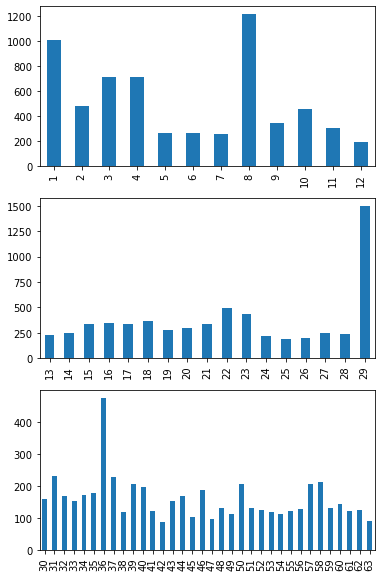

In [11]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(3,1,1)
ax1 = survival_term1.survival_time.value_counts().sort_index().plot(kind = 'bar')
# ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(3,1,2)
ax2 = survival_term2.survival_time.value_counts().sort_index().plot(kind = 'bar')
# ax2.set_ylim([0,8200])
ax2 = fig.add_subplot(3,1,3)
ax2 = survival_term3.survival_time.value_counts().sort_index().plot(kind = 'bar')

#### xgboost

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(survival_term1.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 survival_term1.survival_time,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape #, X_valid.shape, y_valid.shape

((4376, 240), (4376,), (1876, 240), (1876,))

In [ ]:
import xgboost as xgb

np.random.seed(42)

xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000)


# eval_set = [(X_train.drop('acc_id', axis=1), y_train), (X_valid.drop('acc_id', axis=1), y_valid)]

xg_clf.fit(X_train.drop('acc_id', axis=1),y_train, sample_weight = w1)#, eval_set = eval_set)

In [23]:
from sklearn.metrics import f1_score
y_pred = xg_clf.predict(X_test.drop('acc_id', axis=1))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

C:\ProgramData\Anaconda3\envs\mypython\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.5053304904051172, 0.488237927843939)

(0, 420)

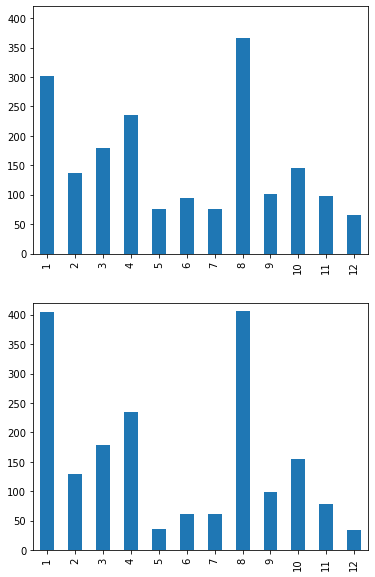

In [29]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,420])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,420])

In [12]:
# sample_weight에 입력 할 list 생성

# 기본 공식
# 낮은 % / 높은 % ( 둘이 합쳤을 떄 100% 기준 )

import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

dic = get_class_weights(y_test)
# dic = {1:1.8, 2:1.4, 3:1.4, 4:0.3}
w1 = np.array(y_test.map(dic))

dic

{10: 2.52,
 8: 1.0,
 4: 1.56,
 5: 4.82,
 1: 1.21,
 11: 3.73,
 9: 3.59,
 6: 3.89,
 2: 2.67,
 3: 2.04,
 12: 5.55,
 7: 4.82}

#### extra tree

In [30]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

# eval_set = [(X_train, y_train), (X_valid, y_valid)]

OVR = OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 800, max_depth = 30,
                                 criterion = 'gini', random_state = 42))
# {class_label:weight}의 dic으로 class_weight 인자에 할당 가능
# balanced, balanced_subsample
                          

OVR.fit(X_train.drop('acc_id', axis=1), y_train)

print('One vs Rest accuracy : %f' % OVR.score(X_train.drop('acc_id', axis=1), y_train))

One vs Rest accuracy : 0.989031


In [31]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = OVR.predict(X_test.drop('acc_id', axis=1))
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.5197228144989339, 0.49724891328913573)

(0, 450)

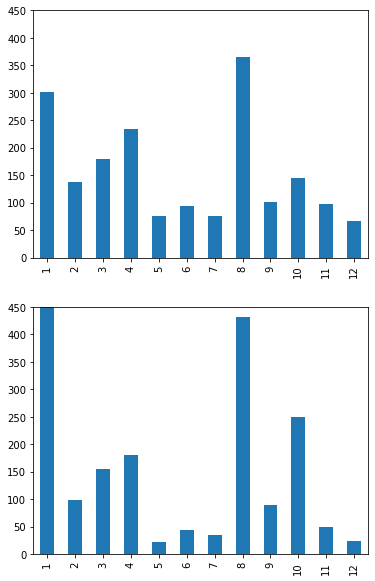

In [33]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,450])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,450])

#### dealing with imbalanced data (at least for non-retain)

https://datascienceschool.net/view-notebook/c1a8dad913f74811ae8eef5d3bedc0c3/ 참고

개인 노트북에 저장해두기

- 이진 분류시 ENN기법을 통해 0 class의 precision을 극대화
- 이탈의 경우 분류 벨런스가 좋은 undersampling의 Tomek's link method를 사용하거나 
- data양이 너무 적으므로 SMOTE+ENN방식을 사용
- 두가지를 비교한 후 최적의 방법을 통해 data balancing하여 잔존 데이터와 함께 분석
- 비교한 두 가지를 leaderboard를 통해 최종 결정

    smote의 경우 ratio = 'minority'로 하여 (무조건 majority하지 말고) 실행해보기
    
    
    multiclass의 smote가 어려울 경우 randomforest에는 이 방법이 있음
    rf = RandomForestClassifier(class_weight="balanced")
    - multiclass의 SMOTE가 안될 경우 아래 library 찾아보기
    - SpreadSubsample
    - ROSE

    data sampling은 ltj_class_weight,smote,featureselection과 colab에서 시행 완료

gridesearch dmatrix version

In [ ]:
# cv를 이러한 형태로도 넣어줄 수 있음
from sklearn.model_selection import PredefinedSplit
X, y, train_valid_indices = train_valid_merge(data_train, data_valid)
train_valid_merge_indices = PredefinedSplit(test_fold=train_valid_indices)

In [ ]:
# dtrain = trainx, predictors = trainy
def modelfit(alg, dtrain, predictors, useTrainCV = True, cv_folds=5, early_stopping_rounds = 50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label = dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'], nfold = cv_folds, metrics = 'auc', early_stopping_rounds = early_stopping_rounds, show_progress = False)
        alg.set_params(n_estimators = cvresult.shape[0])
        
        # Fit the algorithm on the data
        alg.fit(dtrain[predictors], dtrain['Disbursed'], eval_metric = 'auc')
        
        # Predict training set:
#         dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]


param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[2,3,4]
}

grid2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=2000, max_depth=5,
min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'reg:linear', nthread=4, scale_pos_weight=1, random_state=4),
param_grid = param_test2, scoring='neg_mean_squared_error', n_jobs=4,iid=False, cv=10, verbose=20)
grid2.fit(X_train,y_train)
# Mean cross-validated score of the best_estimator
print(grid2.best_params_, np.sqrt(np.abs(grid2.best_score_))), print(np.sqrt(np.abs(grid2.score(X_train, y_train))))
modelfit(grid2.best_estimator_, X_train, y_train)
print(np.sqrt(np.abs(grid2.score(X_train, y_train))))

In [ ]:
y_pred = np.where(dtrain_predprob > 0.5,1,0)

In [ ]:
import sys
import math
 
import numpy as np
from sklearn.grid_search import GridSearchCV
 
sys.path.append('xgboost/wrapper/')
import xgboost as xgb
 
 
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = {label: i for i, label in enumerate(sorted(set(y)))}
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
def logloss(y_true, Y_pred):
    label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
    return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf for y, label in zip(Y_pred, y_true)) / len(Y_pred)


def main():
    clf = XGBoostClassifier(
        eval_metric = 'auc',
        num_class = 2,
        nthread = 4,
        silent = 1,
        )
    parameters = {
        'num_boost_round': [100, 250, 500],
        'eta': [0.05, 0.1, 0.3],
        'max_depth': [6, 9, 12],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
    }
    clf = GridSearchCV(clf, parameters, n_jobs=1, cv=2)
    
    clf.fit([[1,2], [3,4], [2,1], [4,3], [1,0], [4,5]], ['a', 'b', 'a', 'b', 'a', 'b'])
    best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
    print('score:', score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    print('predicted:', clf.predict([[1,1]]))


if __name__ == '__main__':
    main()

In [ ]:
# model.__class__.__name__

### minus, plus 와 minuss, pluss 중 선택

In [534]:
merge_all_flatten = pd.read_csv('./merge_all_flatten.csv')

In [535]:
merge_all_flatten.head(10)

,acc_id,temp_cnt_x,private_shop,level_x,party_exp,pledge_cnt,random_attacker_cnt_x,random_defender_cnt_x,same_pledge_cnt_x,etc_cnt_x,...,random_defender_cnt_4_y,same_pledge_cnt_4_y,temp_cnt_4_y,etc_cnt_4_y,combat_play_time_4,pledge_rank_4,amount_spent_1,amount_spent_2,amount_spent_3,amount_spent_4
0,2,0.000000,84.900753,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,5,0.479728,0.000000,173.0,0.695285,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.715313,0.000000,1.384363,0.417618,3.661882,66814.0,0.000000,0.000000,0.000000,0.000000
2,8,3.837822,0.000000,1922.0,0.000000,0.128368,4.270875,0.000000,0.000000,0.225223,...,4.077286,4.774303,21.556504,6.243030,29.782361,22331.0,1.056123,0.000000,0.000000,0.348521
3,17,3.358094,0.000000,687.0,8.823094,0.000000,0.000000,2.366129,12.398273,0.563058,...,1.859815,0.000000,10.778252,2.526941,15.140507,2673.0,0.000000,0.000000,0.000000,0.000000
4,20,0.959456,2.917510,930.0,0.110339,1.540422,0.000000,2.366129,0.000000,21.621413,...,2.360534,3.978586,7.317346,11.672059,18.448062,2500.0,0.000000,0.070408,0.826123,0.000000
5,21,2.878367,0.000000,452.0,0.436053,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.014157,0.087337,23466.0,0.000000,0.000000,2.346940,0.348521
6,31,6.236461,0.000000,476.0,0.006899,0.000000,0.000000,17.745967,0.000000,15.315168,...,1.573689,0.000000,1.779895,7.333083,6.026689,27377.0,0.000000,0.000000,0.000000,0.000000
7,38,23.026933,0.000000,3221.0,0.096362,0.000000,0.000000,7.098387,0.000000,5.743188,...,0.286125,0.000000,4.153088,4.834455,8.025469,12834.0,0.442398,0.586735,0.000000,5.280616
8,41,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4679.0,0.000000,0.000000,0.000000,0.035204
9,43,0.959456,0.000000,436.0,0.000000,0.000000,0.000000,1.183064,0.000000,0.000000,...,0.214594,0.000000,9.097240,3.843498,3.875938,6979.0,3.696431,0.000000,0.000000,0.000000


In [536]:
merge_all_flatten.shape

(40000, 403)

In [573]:
merge_all = pd.merge(merge_all_flatten, train_label, on = 'acc_id')

In [546]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all.drop(['acc_id', 'minus', 'plus',
                                                                           'amount_spent_y',
                                                                           'total_spent',
                                                                          'secession',
                                                                          'survival_time'], axis=1),
                                                    merge_all.secession,
                                                    test_size = 0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 400), (7000, 400), (12000, 400), (21000,), (7000,), (12000,))

In [542]:
import xgboost as xgb

np.random.seed(42)


xg_bin_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)


eval_set = [(X_train, y_train), (X_valid, y_valid)]

xg_bin_clf.fit(X_train,y_train, eval_set = eval_set, early_stopping_rounds=25)

[0]	validation_0-error:0.264095	validation_1-error:0.278857
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 25 rounds.
[1]	validation_0-error:0.256238	validation_1-error:0.269857
[2]	validation_0-error:0.246952	validation_1-error:0.263857
[3]	validation_0-error:0.24781	validation_1-error:0.262714
[4]	validation_0-error:0.246619	validation_1-error:0.263857
[5]	validation_0-error:0.244952	validation_1-error:0.262
[6]	validation_0-error:0.239619	validation_1-error:0.259143
[7]	validation_0-error:0.235905	validation_1-error:0.255571
[8]	validation_0-error:0.235238	validation_1-error:0.255714
[9]	validation_0-error:0.235952	validation_1-error:0.258286
[10]	validation_0-error:0.23319	validation_1-error:0.258571
[11]	validation_0-error:0.232143	validation_1-error:0.257
[12]	validation_0-error:0.231429	validation_1-error:0.256286
[13]	validation_0-error:0.230524	validation_1-error:0.256429
[14

[133]	validation_0-error:0.171762	validation_1-error:0.222714
[134]	validation_0-error:0.171762	validation_1-error:0.222286
[135]	validation_0-error:0.17181	validation_1-error:0.221857
[136]	validation_0-error:0.171619	validation_1-error:0.222
[137]	validation_0-error:0.171238	validation_1-error:0.222571
[138]	validation_0-error:0.171048	validation_1-error:0.222571
[139]	validation_0-error:0.170524	validation_1-error:0.222714
[140]	validation_0-error:0.16981	validation_1-error:0.222571
[141]	validation_0-error:0.168381	validation_1-error:0.222286
[142]	validation_0-error:0.168381	validation_1-error:0.221714
[143]	validation_0-error:0.168143	validation_1-error:0.222429
[144]	validation_0-error:0.167619	validation_1-error:0.222429
[145]	validation_0-error:0.167	validation_1-error:0.222143
[146]	validation_0-error:0.166143	validation_1-error:0.222143
[147]	validation_0-error:0.16581	validation_1-error:0.222429
[148]	validation_0-error:0.165	validation_1-error:0.222143
[149]	validation_0-e

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [540]:
from sklearn.metrics import accuracy_score, f1_score
# minuss, pluss 제거
y_pred = np.where(xg_bin_clf.predict_proba(X_test)[:,1] > 0.5,1,0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.7889166666666667, 0.759563360227812, 0.7885170225043278, 5466, 6932)

In [543]:
from sklearn.metrics import accuracy_score, f1_score
# minus, plus 제거
y_pred = np.where(xg_bin_clf.predict_proba(X_test)[:,1] > 0.5,1,0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.7893333333333333, 0.7606060606060605, 0.7899232662516288, 5456, 6907)

### 변수 추가 완료 (완성본)

In [566]:
merge_all_flatten = pd.read_csv('./merge_all_flatten.csv')

In [567]:
merge_all_flatten.shape

(40000, 401)

In [547]:
import xgboost as xgb

np.random.seed(42)


xg_bin_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)


eval_set = [(X_train, y_train), (X_valid, y_valid)]

xg_bin_clf.fit(X_train,y_train, eval_set = eval_set, early_stopping_rounds=25)

[0]	validation_0-error:0.26219	validation_1-error:0.280143
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 25 rounds.
[1]	validation_0-error:0.252095	validation_1-error:0.273
[2]	validation_0-error:0.249524	validation_1-error:0.266429
[3]	validation_0-error:0.247524	validation_1-error:0.266857
[4]	validation_0-error:0.246476	validation_1-error:0.266286
[5]	validation_0-error:0.243952	validation_1-error:0.264143
[6]	validation_0-error:0.24281	validation_1-error:0.261429
[7]	validation_0-error:0.241	validation_1-error:0.259571
[8]	validation_0-error:0.239524	validation_1-error:0.259857
[9]	validation_0-error:0.239667	validation_1-error:0.262571
[10]	validation_0-error:0.238	validation_1-error:0.261143
[11]	validation_0-error:0.237952	validation_1-error:0.261143
[12]	validation_0-error:0.236571	validation_1-error:0.261
[13]	validation_0-error:0.236048	validation_1-error:0.259286
[14]	vali

[134]	validation_0-error:0.181857	validation_1-error:0.240429
[135]	validation_0-error:0.181571	validation_1-error:0.240571
[136]	validation_0-error:0.181048	validation_1-error:0.240571
[137]	validation_0-error:0.181048	validation_1-error:0.239857
[138]	validation_0-error:0.180524	validation_1-error:0.240286
[139]	validation_0-error:0.180143	validation_1-error:0.240571
[140]	validation_0-error:0.180048	validation_1-error:0.240286
[141]	validation_0-error:0.179857	validation_1-error:0.240286
[142]	validation_0-error:0.179476	validation_1-error:0.240143
[143]	validation_0-error:0.178952	validation_1-error:0.239571
[144]	validation_0-error:0.178714	validation_1-error:0.239571
[145]	validation_0-error:0.178619	validation_1-error:0.239857
[146]	validation_0-error:0.178143	validation_1-error:0.239286
[147]	validation_0-error:0.177571	validation_1-error:0.239286
[148]	validation_0-error:0.177429	validation_1-error:0.239429
[149]	validation_0-error:0.176667	validation_1-error:0.239
[150]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = np.where(xg_bin_clf.predict_proba(X_test)[:,1] > 0.5,1,0)
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

- extra tree 시험

In [549]:
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

extra_clf = ExtraTreesClassifier(n_estimators = 1000, max_depth = 30,
                                 criterion = 'gini', random_state = 42)
extra_clf.fit(X_train, y_train)
y_pred = extra_clf.predict(X_test)


precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
print('accuracy :', accuracy_score(y_test, y_pred),
     'f1-score :', f1_score(y_test, y_pred),
     'precision :', precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum())

accuracy : 0.7758333333333334 f1-score : 0.7387334887334887 precision : 0.7679542602147539 5507 7171


In [550]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      6533
           1       0.79      0.70      0.74      5467

    accuracy                           0.78     12000
   macro avg       0.78      0.77      0.77     12000
weighted avg       0.78      0.78      0.77     12000



- regressor

In [579]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all.drop(['acc_id',
                                                                           'amount_spent_y',
                                                                           'total_spent',
                                                                          'secession',
                                                                          'survival_time'], axis=1),
                                                    merge_all.amount_spent_y,
                                                    test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 400), (12000, 400), (28000,), (12000,))

In [555]:
from sklearn.ensemble import ExtraTreesRegressor

np.random.seed(42)

extra_clf = ExtraTreesRegressor(n_estimators = 1000, max_depth = 30,
                                random_state = 42, criterion = 'mae')
extra_clf.fit(X_train, y_train)

y_pred = extra_clf.predict(X_test)

In [556]:
from sklearn.metrics import mean_squared_error

y_pred = extra_clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.687463


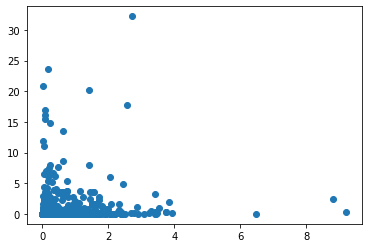

In [584]:
plt.scatter(y_pred, y_test)

In [583]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bag_reg = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 800, random_state = 42)

bag_reg.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort=False,
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_sample

In [ ]:
pred = bag_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: %f" % (rmse))

- lasso

In [ ]:
alpha = [i/100 for i in range(1,400)]
model3 = sklearn.linear_model.LassoCV(n_alphas = 200, alphas = alpha , cv = 10)
model3.fit(train_X, y)
prediction3 = model3.predict(test_X)
score_3 = model3.score(test_X, test_y) 

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# create and evaluate pipeline
models = []
models.append( LinearRegression() )
models.append( Ridge(alpha=1.0) )
models.append( Lasso(alpha=0.5) )
models.append( ElasticNet(alpha=0.1, l1_ratio=0.5) )

Xw = X
results = evalModels(models, Xw, y, boxPlotOn=True)

In [ ]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# create and evaluate pipeline
models = []
models.append( DecisionTreeRegressor(max_leaf_nodes=9, min_samples_leaf=18) )
models.append( ExtraTreeRegressor(criterion='mae', max_leaf_nodes=50, min_samples_leaf=4, min_samples_split=6) )
cart = DecisionTreeRegressor()
models.append( BaggingRegressor(base_estimator=cart, random_state=7, n_estimators=300, max_features=6) )
models.append( RandomForestRegressor(n_estimators=100, max_features=4, criterion='mae', max_leaf_nodes=50, min_samples_split=4) )
models.append( ExtraTreesRegressor(n_estimators=100, max_features=4, max_depth=1000, min_samples_split=6) )

Xw = X
plt.rcParams["figure.figsize"] = [10, 4]
results = evalModels(models, Xw, y, boxPlotOn=True)
plt.rcParams["figure.figsize"] = [6, 4]

## grod search, rfecv 같이 돌리는 코드
- https://stackoverflow.com/questions/55609339/how-to-perform-feature-selection-with-gridsearchcv-in-sklearn-in-python

In [ ]:
X = df[my_features] #all my features
y = df['gold_standard'] #labels

clf = RandomForestClassifier(random_state = 42, class_weight="balanced")
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(10), scoring='auc_roc')

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

#------------- Just pass your RFECV object as estimator here directly --------#

CV_rfc = GridSearchCV(estimator=rfecv, param_grid=param_grid, cv= k_fold, scoring = 'roc_auc')


CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)
print(CV_rfc.best_estimator_)